# London Fire Incidents Dimensionality Reduction

In [1]:
%matplotlib inline

import os
import time
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from scipy import linalg
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix, issparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads
from sklearn.utils.validation import check_non_negative
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances

MACHINE_EPSILON = np.finfo(np.double).eps

import warnings
warnings.filterwarnings('ignore')

### Downloading and loading the data

In [2]:
# Loading the data
# import data_download #This module has to be loaded to download the data automatically

LFB_data = pd.read_excel("LFB-data/LFB Incident data Last 3 years.xlsx")
# LFB_data = pd.read_excel("/content/drive/MyDrive/LFB_Incident_data_Last_3_years.xlsx")
LFB_data.head()

,IncidentNumber,DateOfCall,CalYear,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,...,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),NumCalls
0,000006-01012019,01 Jan 2019,2019,00:01:45,0,Special Service,Special Service,Lift Release,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,333.0,2.0
1,000019-01012019,01 Jan 2019,2019,00:04:33,0,Fire,Secondary Fire,NaN,Outdoor,Tree scrub,...,357.0,Edmonton,NaN,NaN,1.0,1.0,1.0,1.0,333.0,1.0
2,000020-01012019,01 Jan 2019,2019,00:04:39,0,False Alarm,False alarm - Good intent,NaN,Outdoor,Domestic garden (vegetation not equipment),...,318.0,Southgate,NaN,NaN,1.0,1.0,1.0,1.0,333.0,1.0
3,000021-01012019,01 Jan 2019,2019,00:04:44,0,False Alarm,AFA,NaN,Dwelling,Stately Home (part not open to public),...,210.0,Kensington,NaN,NaN,1.0,1.0,1.0,1.0,333.0,1.0
4,000024-01012019,01 Jan 2019,2019,00:05:00,0,Special Service,Special Service,Lift Release,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,...,329.0,Bethnal Green,NaN,NaN,1.0,1.0,1.0,1.0,333.0,1.0


In [3]:
LFB_data.shape

(416213, 39)

### creating a random sample to work with

In [4]:
random.seed(10)
rand_num=random.sample(range(len(LFB_data)), 5000)
rand_num[:10]

[299579, 17083, 224861, 253001, 303086, 7776, 108054, 242525, 257580, 145500]

In [5]:
df = LFB_data.iloc[rand_num]
df.reset_index(inplace=True, drop=True)
df.shape

(5000, 39)

In [6]:
df.to_csv('5000.csv')

In [7]:
# Delete the LFB-data dataframe from memory
del LFB_data

False Alarm        2470
Special Service    1714
Fire                816
Name: IncidentGroup, dtype: int64

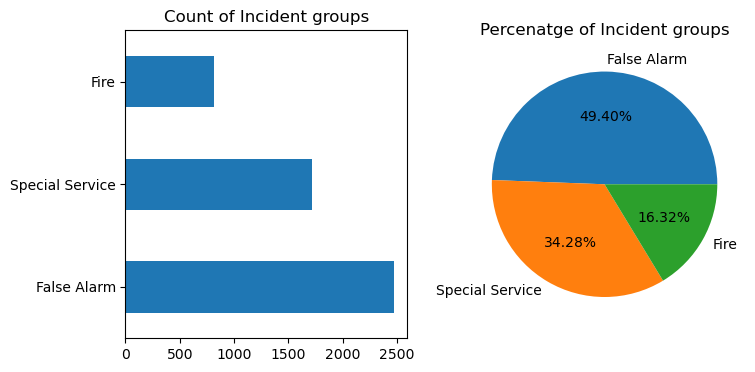

In [8]:
display(df.IncidentGroup.value_counts())

fig = plt.figure(figsize=(8,4))
fig.add_subplot(121)
plt.title("Count of Incident groups")
df.IncidentGroup.value_counts().plot(kind='barh')

fig.add_subplot(122)
plt.title("Percenatge of Incident groups")
plt.pie(data=df['IncidentGroup'], x=df.IncidentGroup.value_counts(),
       labels=['False Alarm', 'Special Service', 'Fire'], autopct='%.2f%%')

fig.labels='off'

## Data Preprocessing

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   IncidentNumber                          5000 non-null   object 
 1   DateOfCall                              5000 non-null   object 
 2   CalYear                                 5000 non-null   int64  
 3   TimeOfCall                              5000 non-null   object 
 4   HourOfCall                              5000 non-null   int64  
 5   IncidentGroup                           5000 non-null   object 
 6   StopCodeDescription                     5000 non-null   object 
 7   SpecialServiceType                      1714 non-null   object 
 8   PropertyCategory                        5000 non-null   object 
 9   PropertyType                            5000 non-null   object 
 10  AddressQualifier                        5000 non-null   obje

#### Time Processing

In [10]:
# Create a new column from the DateOfCall column.
df['MonthOfCall'] = df['DateOfCall'].apply(lambda x: x.split(" ")[1])
df['DayOfcall'] = df['DateOfCall'].apply(lambda x: x.split(" ")[0])


<AxesSubplot:title={'center':'Hourly distribution of incident groups'}, xlabel='HourOfCall', ylabel='Count'>

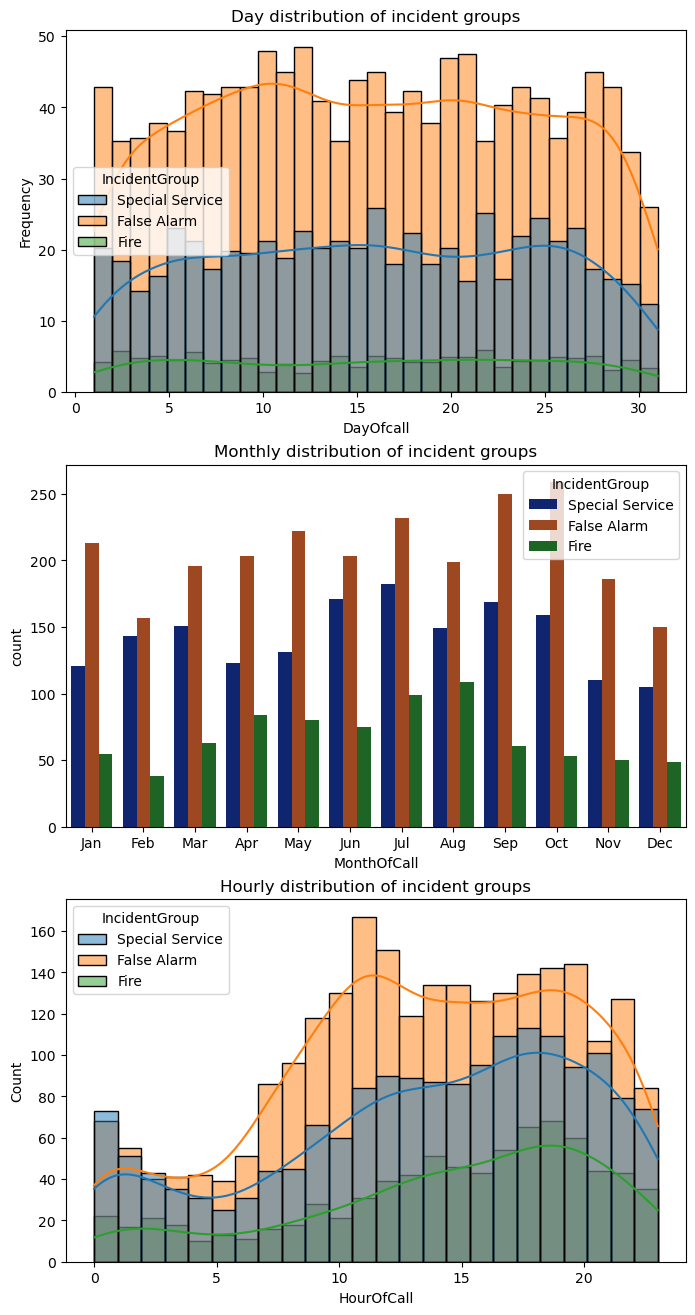

In [11]:

fig=plt.figure(figsize=(8,16))

fig.add_subplot(311)
plt.title("Day distribution of incident groups")
sns.histplot(data=df, x=pd.to_numeric(df['DayOfcall']), kde=True,
            hue=df['IncidentGroup'], stat='frequency', bins=31)

fig.add_subplot(312)
plt.title("Monthly distribution of incident groups")
sns.countplot(data=df, x=df['MonthOfCall'],hue=df['IncidentGroup'],palette='dark',
             order=['Jan','Feb','Mar', 'Apr', 'May','Jun', 'Jul','Aug','Sep', 'Oct','Nov','Dec'])

fig.add_subplot(313)
plt.title("Hourly distribution of incident groups")
sns.histplot(data=df, x=df['HourOfCall'], kde=True,
            hue=df['IncidentGroup'], stat='count', bins=24)

#### Service and group processing

#### Slicing Northing_m and easting_m to 4 last digits

In [12]:
# process Northing and easting data and process it ito categorical data using pandas cut

df['Easting_rounded']= df['Easting_rounded'].apply(lambda x: int(str(x)[2:]))

df['Northing_rounded']= df['Northing_rounded'].apply(lambda x: int(str(x)[2:]))


In [13]:
df.nunique()

IncidentNumber                            5000
DateOfCall                                1362
CalYear                                      4
TimeOfCall                                4829
HourOfCall                                  24
IncidentGroup                                3
StopCodeDescription                          8
SpecialServiceType                          19
PropertyCategory                             9
PropertyType                               195
AddressQualifier                            11
Postcode_full                             2111
Postcode_district                          277
UPRN                                      2187
USRN                                      3978
IncGeo_BoroughCode                          33
IncGeo_BoroughName                          33
ProperCase                                  33
IncGeo_WardCode                            698
IncGeo_WardName                           1013
IncGeo_WardNameNew                        1013
Easting_m    

## Exploratory data analysis

Yellow - Missing Values
Blue - Non Missing


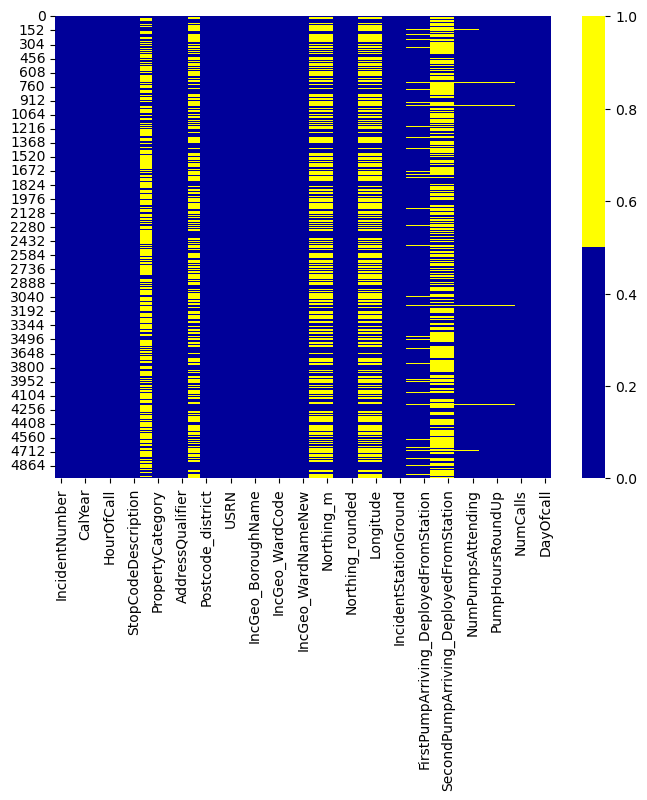

In [14]:
# Lets see if the data has missing values.

plt.figure(figsize = (8,6))
cols = df.columns[:]
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))
print("Yellow - Missing Values\nBlue - Non Missing")

In [15]:
# Drop Unecessary Columns
df.drop(["IncidentNumber","StopCodeDescription","DateOfCall","TimeOfCall","SpecialServiceType","Postcode_full","Postcode_district","UPRN","USRN",
"IncGeo_BoroughName", "IncGeo_BoroughCode", 'Latitude', 'Longitude', "ProperCase","IncGeo_WardCode","IncGeo_WardName",
"IncGeo_WardNameNew","FRS","IncidentStationGround"], axis=1, inplace=True)
df.shape

(5000, 22)

<h6>Ignoring Special service to only focus on <strong>Fire</strong> and <strong>False Alarm</strong>.</h6>

In [16]:
def fire_and_falseAlarm(df):
    df = df[df.label != 'Special Service']
    df.reset_index(inplace=True, drop=True)
    return df

In [17]:
label = df[['IncidentGroup']]
df.drop(["IncidentGroup"], axis=1,inplace=True)

###### convert Num calls to categorical

In [18]:
df["NumCalls"]=df.NumCalls.astype("category")

### Numerical data

In [19]:
# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])

print("Numeric data shape : ",df_numeric.shape)
df_numeric.columns.values

Numeric data shape :  (5000, 13)


array(['CalYear', 'HourOfCall', 'Easting_m', 'Northing_m',
       'Easting_rounded', 'Northing_rounded',
       'FirstPumpArriving_AttendanceTime',
       'SecondPumpArriving_AttendanceTime',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpHoursRoundUp', 'Notional Cost (£)'], dtype=object)

In [20]:
df_numeric.head()

,CalYear,HourOfCall,Easting_m,Northing_m,Easting_rounded,Northing_rounded,FirstPumpArriving_AttendanceTime,SecondPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£)
0,2021,6,NaN,NaN,7450,5550,244.0,NaN,1.0,1.0,1.0,1.0,352.0
1,2019,21,537768.0,195522.0,7750,5550,280.0,383.0,2.0,2.0,2.0,1.0,333.0
2,2021,12,NaN,NaN,4550,8650,440.0,449.0,1.0,2.0,2.0,2.0,692.0
3,2021,11,529679.0,180638.0,9650,650,160.0,NaN,1.0,1.0,1.0,1.0,352.0
4,2021,2,522059.0,172702.0,2050,2750,263.0,NaN,1.0,1.0,1.0,1.0,352.0


In [21]:
df_numeric.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

,count,mean,std,min,25%,50%,75%,max
CalYear,5000.00,2020.53,1.12,2019.00,2020.00,2021.00,2021.00,2022.00
HourOfCall,5000.00,13.57,6.26,0.00,9.00,14.00,19.00,23.00
Easting_m,2241.00,530627.16,10556.05,504594.00,524590.00,530929.00,537494.00,559259.00
Northing_m,2241.00,180538.59,7643.12,157513.00,176095.00,181115.00,185440.00,200220.00
Easting_rounded,5000.00,4925.28,2857.56,50.00,2450.00,4850.00,7350.00,9950.00
Northing_rounded,5000.00,4906.56,2934.75,50.00,2250.00,4950.00,7550.00,9950.00
FirstPumpArriving_AttendanceTime,4681.00,308.68,129.87,2.00,228.00,291.00,370.00,1158.00
SecondPumpArriving_AttendanceTime,1883.00,384.74,142.98,2.00,295.00,364.00,451.50,1156.00
NumStationsWithPumpsAttending,4927.00,1.42,0.79,1.00,1.00,1.00,2.00,8.00
NumPumpsAttending,4927.00,1.57,0.93,1.00,1.00,1.00,2.00,8.00


We can tell from the data above that there are outliers in the numeric data.
For instance, there are values that have a very huge diffrence between the 75th percentile and maximum value

#### Numerical data visualization

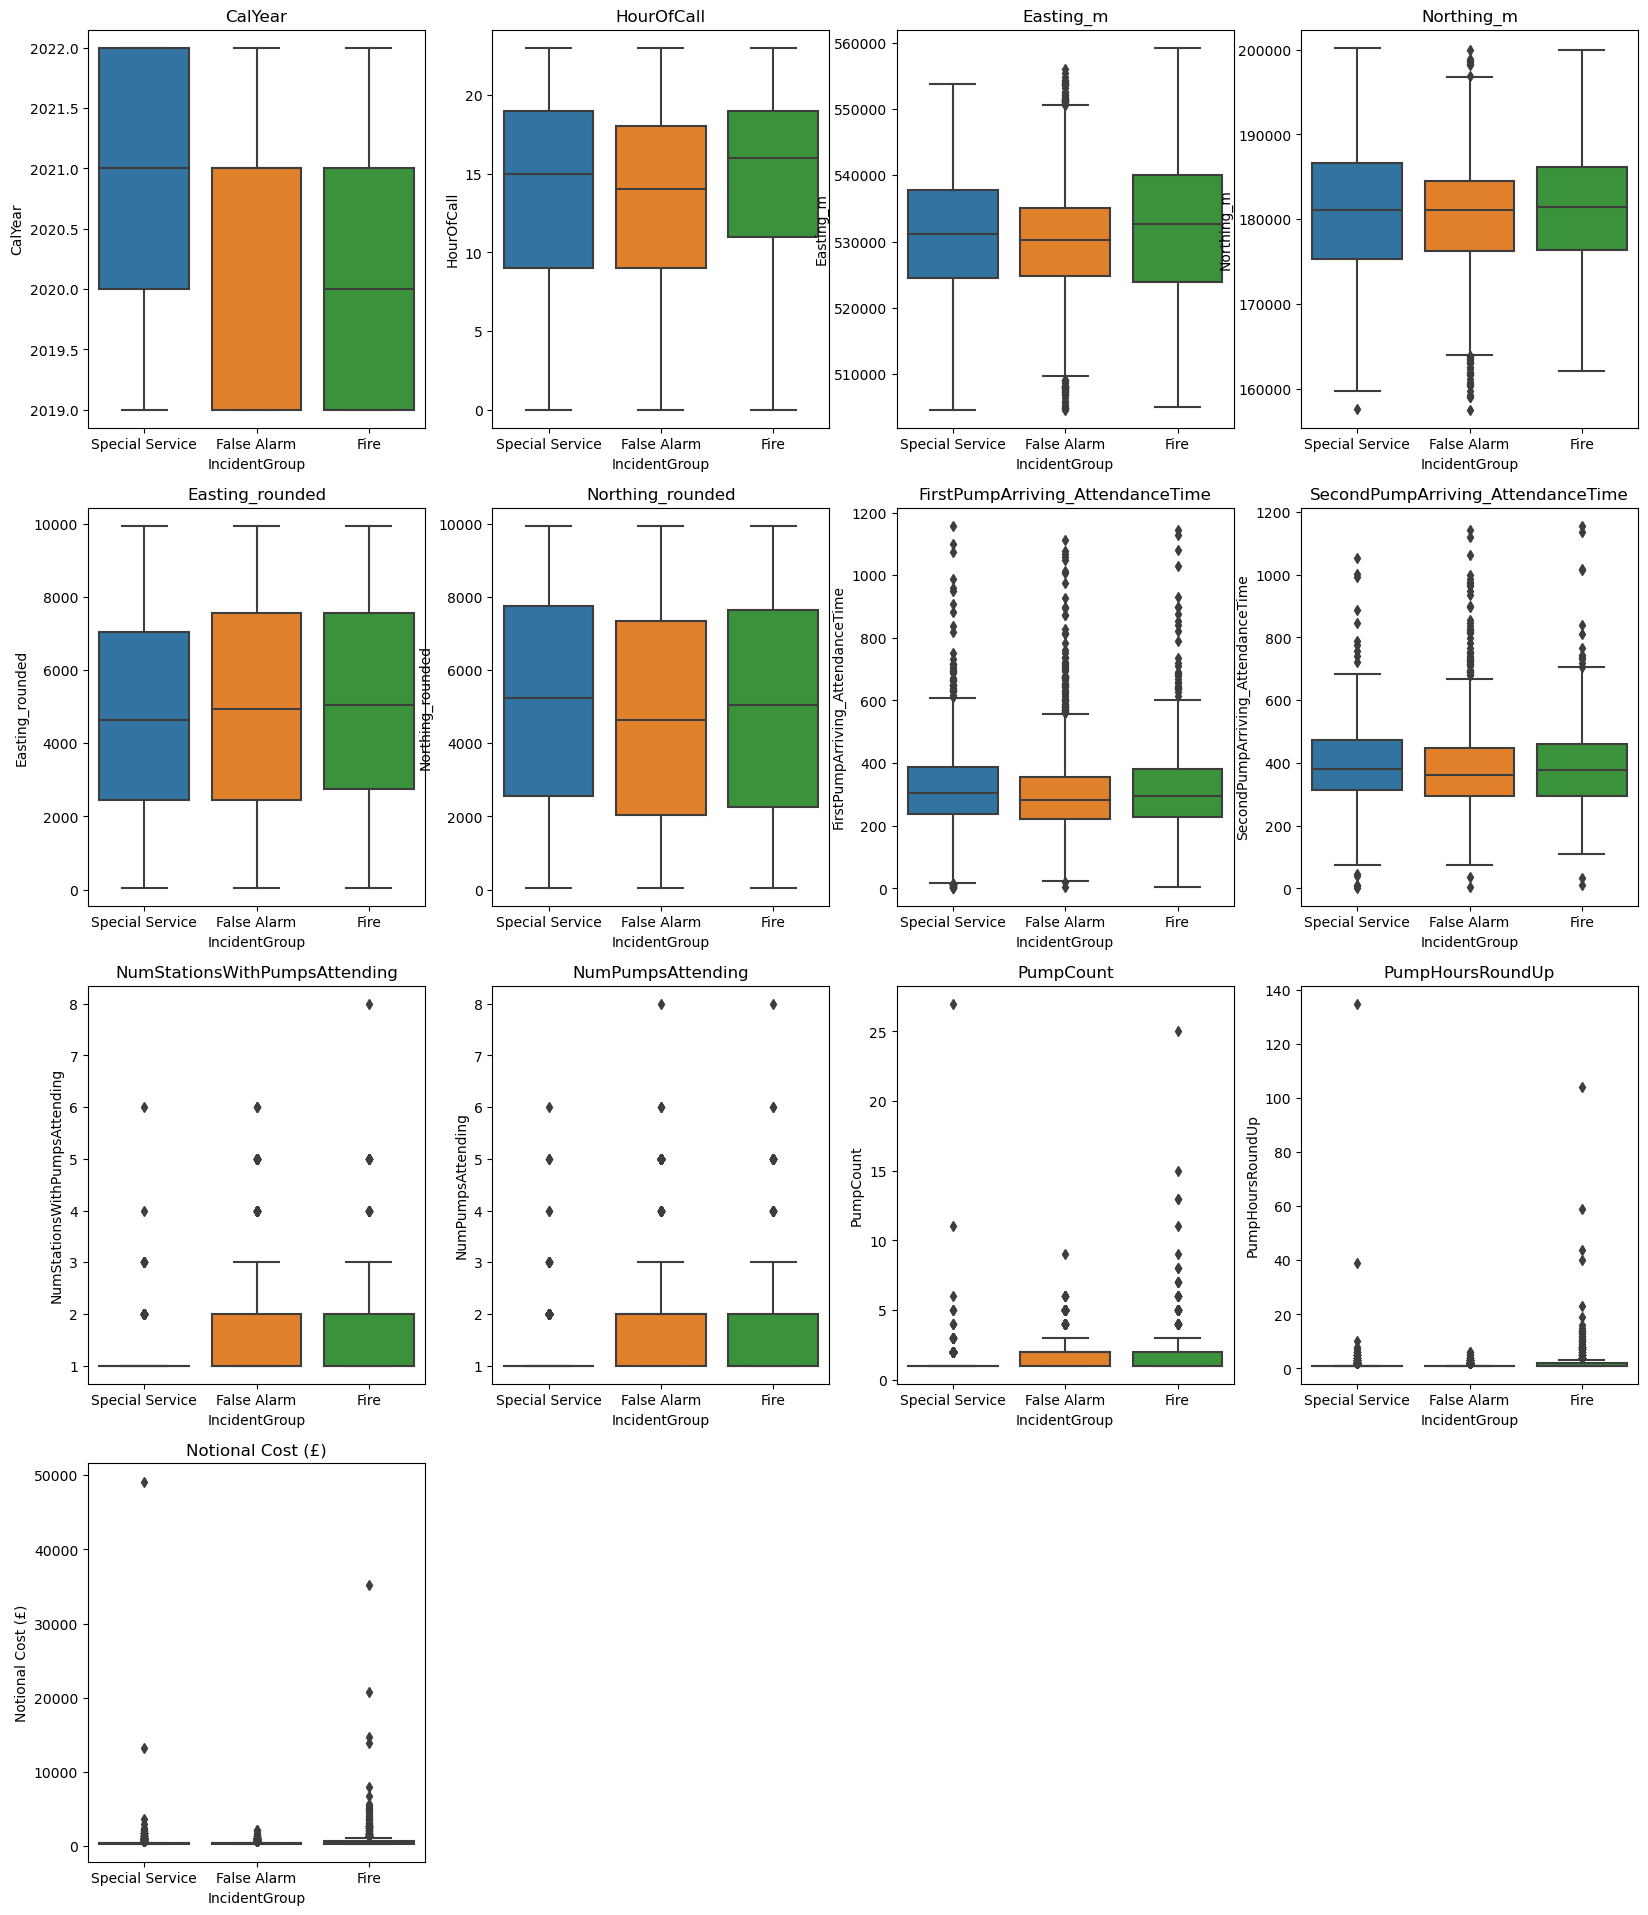

In [22]:
fig = plt.figure(figsize= (20,30))

for i in range(len(df_numeric.columns)):
    column = df_numeric.columns[i]
    sub = fig.add_subplot(5,4, i+1)
    chart = sns.boxplot(data=df_numeric, y=column, x= label['IncidentGroup'])
    chart.set_title(column)

#### Missing values on Numeric data

In [23]:
# Check for any missing values
print("Number of cols with Missing Vals: ",df_numeric.isna().any().sum())
display(df_numeric.isna().sum())

Number of cols with Missing Vals:  9


CalYear                                 0
HourOfCall                              0
Easting_m                            2759
Northing_m                           2759
Easting_rounded                         0
Northing_rounded                        0
FirstPumpArriving_AttendanceTime      319
SecondPumpArriving_AttendanceTime    3117
NumStationsWithPumpsAttending          73
NumPumpsAttending                      73
PumpCount                              36
PumpHoursRoundUp                       36
Notional Cost (£)                      36
dtype: int64

<h6>We need to fix the missing values to cluster around the mean value<br>We will consider randomizing the missing values between 30% and 70%</h6>

In [24]:
for i in df_numeric.columns.values:
    df_numeric.fillna(0, inplace=True)
    # Set 30 and 70th percentile and round off to 2
    rand_30_70 = random.uniform(round(np.percentile(df_numeric[i],30),2), round(np.percentile(df_numeric[i],70),2)) 
    for j in i:
        if j == 0:
            df_numeric.replace(to_replace=0, value=rand_30_70, inplace=True)

#### Outliers in numerical data

In [25]:
for i in df_numeric.columns:
    highest_val = df_numeric[i].mean() + 3*df_numeric[i].std()
    lowest_val = df_numeric[i].min()
    print(f"Range for {i} : ", round(lowest_val,2), " to ",round(highest_val,2))
    
#     Trimming the outliers
    df_numeric[i]= np.where(df_numeric[i]>highest_val, highest_val,
                           np.where(df_numeric[i]<lowest_val, lowest_val,
                                   df_numeric[i]))
#     (df_numeric[i]>=lowest_val)&(df_numeric[i]<=highest_val)

print( "\n","*"*120)
df_numeric.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

Range for CalYear :  2019  to  2023.87
Range for HourOfCall :  0  to  32.34
Range for Easting_m :  0.0  to  1029847.83
Range for Northing_m :  0.0  to  350731.93
Range for Easting_rounded :  50  to  13497.97
Range for Northing_rounded :  50  to  13710.81
Range for FirstPumpArriving_AttendanceTime :  0.0  to  728.68
Range for SecondPumpArriving_AttendanceTime :  0.0  to  763.03
Range for NumStationsWithPumpsAttending :  0.0  to  3.81
Range for NumPumpsAttending :  0.0  to  4.37
Range for PumpCount :  0.0  to  5.06
Range for PumpHoursRoundUp :  0.0  to  10.04
Range for Notional Cost (£) :  0.0  to  3531.55

 ************************************************************************************************************************


,count,mean,std,min,25%,50%,75%,max
CalYear,5000.00,2020.53,1.12,2019.00,2020.00,2021.00,2021.00,2022.00
HourOfCall,5000.00,13.57,6.26,0.00,9.00,14.00,19.00,23.00
Easting_m,5000.00,237827.09,264006.91,0.00,0.00,0.00,529893.50,559259.00
Northing_m,5000.00,80917.39,89938.18,0.00,0.00,0.00,180584.25,200220.00
Easting_rounded,5000.00,4925.28,2857.56,50.00,2450.00,4850.00,7350.00,9950.00
Northing_rounded,5000.00,4906.56,2934.75,50.00,2250.00,4950.00,7550.00,9950.00
FirstPumpArriving_AttendanceTime,5000.00,287.24,139.54,0.00,213.75,284.00,363.00,728.68
SecondPumpArriving_AttendanceTime,5000.00,143.72,201.78,0.00,0.00,0.00,317.00,763.03
NumStationsWithPumpsAttending,5000.00,1.37,0.71,0.00,1.00,1.00,2.00,3.81
NumPumpsAttending,5000.00,1.52,0.84,0.00,1.00,1.00,2.00,4.37


#### Scalling Numerical data

In [26]:
scaler = MinMaxScaler(feature_range=(0,2))
df_numeric=pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)
df_numeric.head(5)

,CalYear,HourOfCall,Easting_m,Northing_m,Easting_rounded,Northing_rounded,FirstPumpArriving_AttendanceTime,SecondPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£)
0,1.333333,0.521739,0.000000,0.000000,1.494949,1.111111,0.669702,0.000000,0.52548,0.457868,0.395647,0.199292,0.199346
1,0.000000,1.826087,1.923145,1.953072,1.555556,1.111111,0.768510,1.003886,1.05096,0.915736,0.791295,0.199292,0.188586
2,1.333333,1.043478,0.000000,0.000000,0.909091,1.737374,1.207659,1.176879,0.52548,0.915736,0.791295,0.398584,0.391896
3,1.333333,0.956522,1.894217,1.804395,1.939394,0.121212,0.439149,0.000000,0.52548,0.457868,0.395647,0.199292,0.199346
4,1.333333,0.173913,1.866967,1.725122,0.404040,0.545455,0.721851,0.000000,0.52548,0.457868,0.395647,0.199292,0.199346


### Categorical Data

In [27]:
df_categorical = df.select_dtypes(exclude=[np.number])
print(df_categorical.shape)
print( "\n","-"*120)
df_categorical.columns.values

(5000, 8)

 ------------------------------------------------------------------------------------------------------------------------


array(['PropertyCategory', 'PropertyType', 'AddressQualifier',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation', 'NumCalls',
       'MonthOfCall', 'DayOfcall'], dtype=object)

In [28]:
df_categorical.head(5)

,PropertyCategory,PropertyType,AddressQualifier,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_DeployedFromStation,NumCalls,MonthOfCall,DayOfcall
0,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Within same building,Battersea,NaN,1.0,Nov,18
1,Road Vehicle,Car,In street outside gazetteer location,Chingford,Enfield,1.0,Mar,08
2,Dwelling,House - single occupancy,Correct incident location,Northolt,Northolt,1.0,Mar,28
3,Non Residential,Purpose built office,Correct incident location,Soho,NaN,1.0,Jun,30
4,Non Residential,Petrol station,Correct incident location,Wandsworth,NaN,2.0,Nov,29


In [29]:
# Show unique values for each categorcal variable

df_categorical.nunique()

PropertyCategory                            9
PropertyType                              195
AddressQualifier                           11
FirstPumpArriving_DeployedFromStation     102
SecondPumpArriving_DeployedFromStation    100
NumCalls                                   18
MonthOfCall                                12
DayOfcall                                  31
dtype: int64

### Joining dataframes

In [30]:
X_df2 = pd.concat([df_numeric, df_categorical], axis = 1)
X_df2.shape

(5000, 21)

In [31]:
X_df2.sample(7)

,CalYear,HourOfCall,Easting_m,Northing_m,Easting_rounded,Northing_rounded,FirstPumpArriving_AttendanceTime,SecondPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,...,PumpHoursRoundUp,Notional Cost (£),PropertyCategory,PropertyType,AddressQualifier,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_DeployedFromStation,NumCalls,MonthOfCall,DayOfcall
164,1.333333,0.695652,0.000000,0.000000,0.464646,1.272727,0.518745,0.51898,0.52548,0.915736,...,0.199292,0.199346,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,Brixton,Brixton,1.0,Apr,15
2421,2.000000,1.304348,1.827565,1.842293,0.202020,0.888889,0.000000,0.00000,0.52548,0.457868,...,0.199292,0.206142,Outdoor,Road surface/pavement,On motorway / elevated road,NaN,NaN,2.0,Oct,27
1167,2.000000,0.956522,0.000000,0.000000,1.414141,1.171717,0.466596,0.00000,0.52548,0.457868,...,0.199292,0.206142,Dwelling,Purpose Built Flats/Maisonettes - 10 or more s...,Correct incident location,Battersea,NaN,1.0,Sep,08
1636,0.666667,0.086957,1.834599,1.801269,0.606061,0.060606,0.408957,0.00000,0.52548,0.457868,...,0.199292,0.195948,Outdoor Structure,Small refuse/rubbish container,In street outside gazetteer location,Southall,NaN,1.0,Aug,22
4196,0.000000,2.000000,0.000000,0.000000,1.959596,0.929293,0.529723,0.00000,0.52548,0.457868,...,0.199292,0.191984,Dwelling,House - single occupancy,Correct incident location,Southgate,NaN,1.0,Nov,19
604,2.000000,1.565217,0.000000,0.000000,1.676768,0.363636,0.741064,0.00000,0.52548,0.457868,...,0.199292,0.199346,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Correct incident location,Tooting,NaN,1.0,Feb,06
2221,1.333333,1.391304,0.000000,0.000000,0.060606,1.979798,0.529723,0.00000,0.52548,0.915736,...,0.199292,0.199346,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,Norbury,NaN,1.0,Apr,18


#### dividing dataframes by pumps

In [32]:
# Dataframe with only 1 pump
X_df1 = X_df2.drop(['SecondPumpArriving_AttendanceTime','SecondPumpArriving_DeployedFromStation'], axis=1)
X_df1.sample(7)

,CalYear,HourOfCall,Easting_m,Northing_m,Easting_rounded,Northing_rounded,FirstPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),PropertyCategory,PropertyType,AddressQualifier,FirstPumpArriving_DeployedFromStation,NumCalls,MonthOfCall,DayOfcall
1498,2.000000,1.304348,0.000000,0.000000,0.404040,0.464646,0.000000,0.52548,0.457868,0.395647,0.199292,0.206142,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Within same building,NaN,3.0,Sep,24
4068,1.333333,0.173913,1.894056,1.835321,1.939394,0.747475,0.839872,0.52548,0.915736,0.791295,0.199292,0.199346,Non Residential,Other industrial processing plant,Correct incident location,Kentish Town,1.0,Jul,03
1632,0.000000,1.652174,0.000000,0.000000,0.020202,1.656566,0.321128,0.52548,0.457868,0.395647,0.199292,0.191984,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Within same building,Chiswick,1.0,Sep,22
2186,2.000000,0.782609,1.899013,1.922625,0.202020,0.484848,0.864574,0.52548,0.457868,0.395647,0.398584,0.412283,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,Southgate,1.0,May,11
554,0.666667,1.739130,0.000000,0.000000,1.050505,0.303030,1.169234,0.52548,0.457868,0.395647,0.199292,0.195948,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,Hillingdon,1.0,Dec,25
4648,1.333333,0.782609,1.879154,1.788283,1.090909,1.818182,0.760276,1.05096,0.915736,0.791295,0.398584,0.398692,Outdoor Structure,Pipe or drain,In street outside gazetteer location,Kensington,1.0,Jun,10
1963,1.333333,0.086957,1.940110,1.747518,0.505051,0.989899,1.163744,1.05096,0.915736,0.791295,0.199292,0.199346,Road Vehicle,Motorcycle,On motorway / elevated road,Lee Green,4.0,Sep,02


### One hot encoding

In [33]:
X_df1 = pd.get_dummies(X_df1)
X_df2 = pd.get_dummies(X_df2)

In [34]:
X_df1.head()

,CalYear,HourOfCall,Easting_m,Northing_m,Easting_rounded,Northing_rounded,FirstPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,...,DayOfcall_22,DayOfcall_23,DayOfcall_24,DayOfcall_25,DayOfcall_26,DayOfcall_27,DayOfcall_28,DayOfcall_29,DayOfcall_30,DayOfcall_31
0,1.333333,0.521739,0.000000,0.000000,1.494949,1.111111,0.669702,0.52548,0.457868,0.395647,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,1.826087,1.923145,1.953072,1.555556,1.111111,0.768510,1.05096,0.915736,0.791295,...,0,0,0,0,0,0,0,0,0,0
2,1.333333,1.043478,0.000000,0.000000,0.909091,1.737374,1.207659,0.52548,0.915736,0.791295,...,0,0,0,0,0,0,1,0,0,0
3,1.333333,0.956522,1.894217,1.804395,1.939394,0.121212,0.439149,0.52548,0.457868,0.395647,...,0,0,0,0,0,0,0,0,1,0
4,1.333333,0.173913,1.866967,1.725122,0.404040,0.545455,0.721851,0.52548,0.457868,0.395647,...,0,0,0,0,0,0,0,1,0,0


In [35]:
# Finding the corelation
cor_df = pd.concat([X_df1, label], ignore_index=False, axis=1)
cor_df.to_csv("correlation1.csv")

In [36]:
cor_df.head()

,CalYear,HourOfCall,Easting_m,Northing_m,Easting_rounded,Northing_rounded,FirstPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,...,DayOfcall_23,DayOfcall_24,DayOfcall_25,DayOfcall_26,DayOfcall_27,DayOfcall_28,DayOfcall_29,DayOfcall_30,DayOfcall_31,IncidentGroup
0,1.333333,0.521739,0.000000,0.000000,1.494949,1.111111,0.669702,0.52548,0.457868,0.395647,...,0,0,0,0,0,0,0,0,0,Special Service
1,0.000000,1.826087,1.923145,1.953072,1.555556,1.111111,0.768510,1.05096,0.915736,0.791295,...,0,0,0,0,0,0,0,0,0,Special Service
2,1.333333,1.043478,0.000000,0.000000,0.909091,1.737374,1.207659,0.52548,0.915736,0.791295,...,0,0,0,0,0,1,0,0,0,Special Service
3,1.333333,0.956522,1.894217,1.804395,1.939394,0.121212,0.439149,0.52548,0.457868,0.395647,...,0,0,0,0,0,0,0,1,0,False Alarm
4,1.333333,0.173913,1.866967,1.725122,0.404040,0.545455,0.721851,0.52548,0.457868,0.395647,...,0,0,0,0,0,0,1,0,0,False Alarm


In [37]:
cor=cor_df.corr()

# Dimensionality reduction

#### T-Stochastic Neighbor Embedding (t-SNE) Using default parameters

In [38]:
X1_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=50).fit_transform(X_df1)
X1_embedded.shape

(5000, 2)

In [39]:
tsne_df1 = pd.DataFrame({"t-SNE 1":X1_embedded[:,0], "t-SNE 2":X1_embedded[:,1], "label":label['IncidentGroup']})


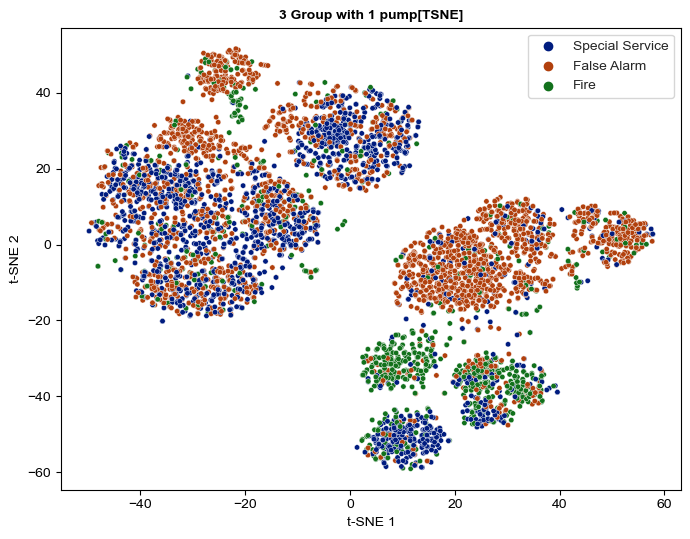

In [40]:
# Plotting the tsne data

fig, ax = plt.subplots(1, figsize=(8,6))
sns.scatterplot(x = 't-SNE 1', y= 't-SNE 2', data = tsne_df1, hue='label', ax = ax, s=15, palette = 'dark')
palette = sns.color_palette("bright", 2)
sns.set_style('whitegrid')
# lim = (tsne_df.min()-5, tsne_df.max()+5)
ax.set_title('3 Group with 1 pump[TSNE]', fontsize = 10, weight = 'bold')
# ax.legend(bbox_to_anchor = (1,1), loc =2, borderaxespad = 0.0)
plt.legend()

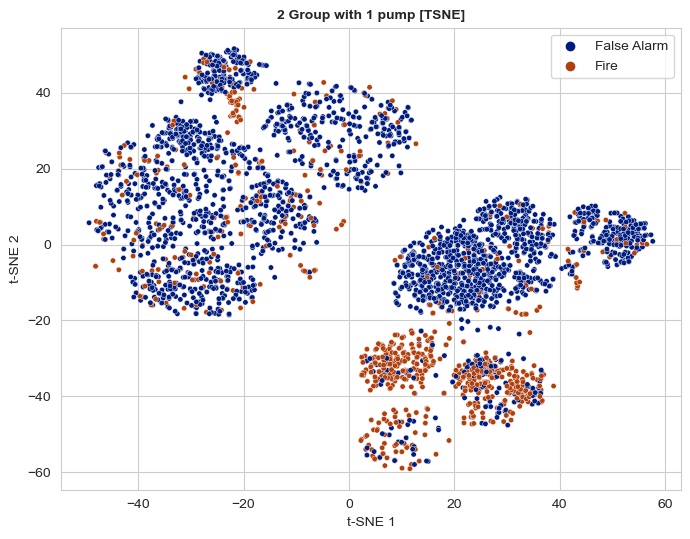

In [41]:
tsne_df1 = tsne_df1[tsne_df1.label != 'Special Service']
# plot 2 groups
fig, ax = plt.subplots(1, figsize=(8,6))
sns.scatterplot(x = 't-SNE 1', y= 't-SNE 2', data = tsne_df1, hue='label', ax = ax, s=15, palette = 'dark')
palette = sns.color_palette("bright", 2)
sns.set_style('whitegrid')
# lim = (tsne_df.min()-5, tsne_df.max()+5)
ax.set_title('2 Group with 1 pump [TSNE]', fontsize = 10, weight = 'bold')
ax.legend()

### Tsne with 2 pumps [First and second Pump]

In [42]:
X2_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=50).fit_transform(X_df2)

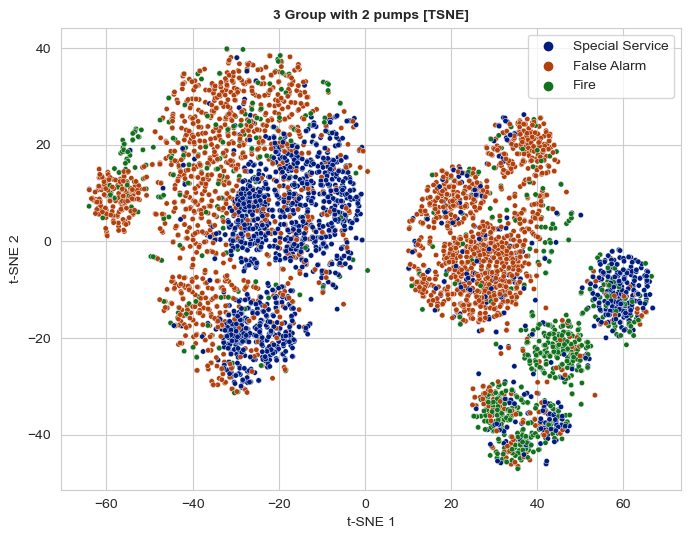

In [43]:
tsne_df2 = pd.DataFrame({"t-SNE 1":X2_embedded[:,0], "t-SNE 2":X2_embedded[:,1],"label":label['IncidentGroup']})
tsne_df2.to_csv("tsne_df2.csv")
# Plotting the tsne data

fig, ax = plt.subplots(1, figsize=(8,6))
sns.scatterplot(x = 't-SNE 1', y= 't-SNE 2', data = tsne_df2, hue='label', ax = ax, s=15, palette = 'dark')
palette = sns.color_palette("bright", 2)
sns.set_style('whitegrid')
# lim = (tsne_df.min()-5, tsne_df.max()+5)
ax.set_title('3 Group with 2 pumps [TSNE]', fontsize = 10, weight = 'bold')
ax.legend()

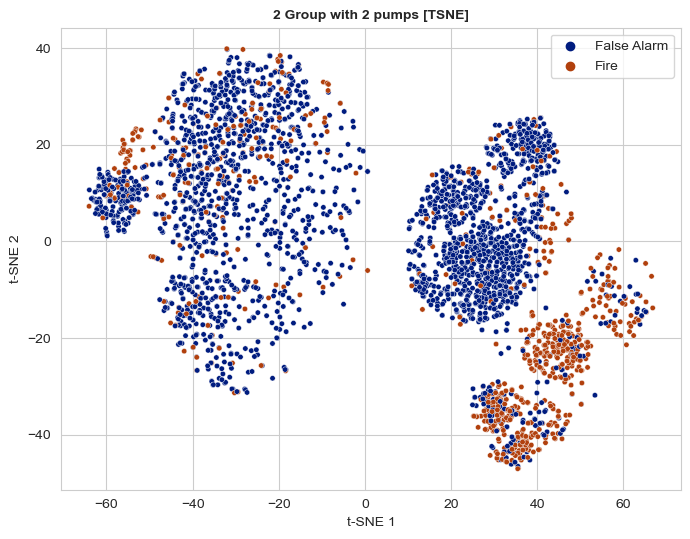

In [44]:
tsne_df2 = tsne_df2[tsne_df2.label != 'Special Service']
tsne_df2.to_csv("tsne_df2.csv")
# plot 2 groups
fig, ax = plt.subplots(1, figsize=(8,6))
sns.scatterplot(x = 't-SNE 1', y= 't-SNE 2', data = tsne_df2, hue='label', ax = ax, s=15, palette = 'dark')
palette = sns.color_palette("bright", 2)
sns.set_style('whitegrid')
ax.set_title('2 Group with 2 pumps [TSNE]', fontsize = 10, weight = 'bold')
ax.legend()

In [46]:
def _joint_probabilities(X, degrees_of_freedom):
    dist = pdist(X, "sqeuclidean")
    dist += 1.
    dist **= (-degrees_of_freedom)
    P= np.maximum(dist / ( np.sum(dist)), MACHINE_EPSILON)
    return P


def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components,
                  skip_num_points=0, compute_error=True):

    X_embedded = params.reshape(n_samples, n_components)
    dist = pdist(X_embedded, "sqeuclidean")
    Dist=dist+ 1.
    dist= Dist**(-degrees_of_freedom)
    Q = np.maximum(dist / (np.sum(dist)), MACHINE_EPSILON)
    dist1=Dist**(-1)
    kl_divergence =np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist1)
    for i in range(skip_num_points, n_samples):
        grad[i] = np.dot(np.ravel(PQd[i]),
                        X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2*(degrees_of_freedom + 1.0) 
    grad *= c

    return kl_divergence, grad

def _gradient_descent(objective, p0, it, n_iter,
                     n_iter_check=1, n_iter_without_progress=300,
                     momentum=0.5, learning_rate=7, min_gain=0.01,
                     min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    tic = time.time()
    for i in range(it, n_iter):
        check_convergence = (i + 1) % n_iter_check == 0
       
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:
            toc = time.time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                     " gradient norm = %.7f"
                     " (%s iterations in %0.3fs)"
                     % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                         "during the last %d episodes. Finished."
                         % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                         % (i + 1, grad_norm))
                break

    return p, error, i


class SDD(BaseEstimator):
   
   
    _EXPLORATION_N_ITER = 300
    _N_ITER_CHECK =50
    def _fit(self, X, degrees_of_freedom, skip_num_points=0):
        random_state=None
        n_samples=X.shape[0]
        P = _joint_probabilities(X,degrees_of_freedom)

        random_state = check_random_state(random_state)

        X_embedded = 1e-4 * random_state.randn(
               n_samples, 2).astype(np.float32)

        return self._tsne(P, degrees_of_freedom, n_samples,X_embedded=X_embedded,skip_num_points=skip_num_points)
    
    def _tsne(self, P, degrees_of_freedom, n_samples, X_embedded, skip_num_points=0):
        """Runs t-SNE."""
        params = X_embedded.ravel()

        opt_args = {
           "it": 0,
           "n_iter_check": 50,
           "min_grad_norm": 1e-7,
           "learning_rate": 7,
           "verbose": 0,
           "kwargs": dict(skip_num_points=skip_num_points),
           "args": [P, degrees_of_freedom, n_samples, 2],
           "n_iter_without_progress": 300,
           "n_iter": 300,
           "momentum": 0.8,
       }
        obj_func = _kl_divergence

        params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                     **opt_args)
        P /= 1
        remaining =2000 - 300
        if it < 300 or remaining > 0:
            opt_args['n_iter'] = 2000
            opt_args['it'] = it + 1
            opt_args['momentum'] = 0.8
            opt_args['n_iter_without_progress'] = 300
            params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                         **opt_args)

        self.n_iter_ = it
        X_embedded = params.reshape(n_samples, 2)
        self.kl_divergence_ = kl_divergence

        return X_embedded


In [47]:
%%time
embedding=SDD()
X_SDD1 = embedding._fit(X_df1,degrees_of_freedom=1)
X_SDD2 = embedding._fit(X_df2,degrees_of_freedom=1)

Wall time: 1h 23min 29s


In [48]:
sdd_df1 = pd.DataFrame({"X":X_SDD1[:,0], "Y":X_SDD1[:,1], "label":label['IncidentGroup']})
sdd_df2 = pd.DataFrame({"X":X_SDD2[:,0], "Y":X_SDD2[:,1], "label":label['IncidentGroup']})
sdd_df2.to_csv("sdd_df2.csv")

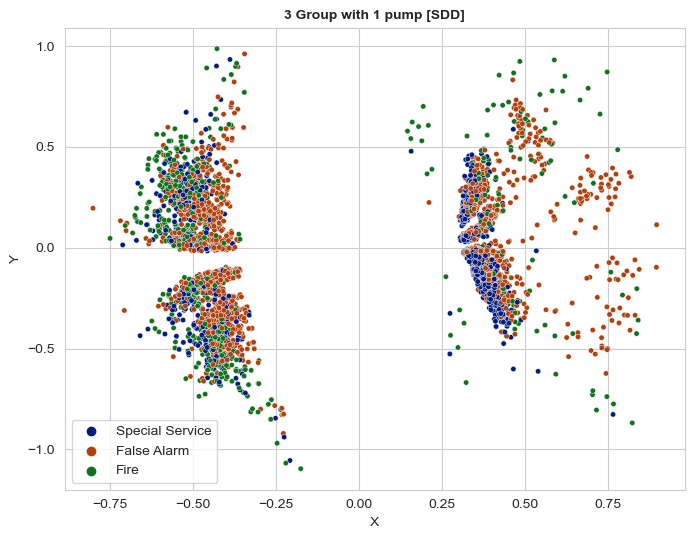

In [49]:
# Plotting the sdd data

fig, ax = plt.subplots(1, figsize=(8,6))
sns.scatterplot(x = sdd_df1.X, y= sdd_df1.Y, data = sdd_df1, hue='label', ax = ax, s=15, palette = 'dark')
palette = sns.color_palette("bright", 2)
sns.set_style('whitegrid')
# lim = (tsne_df.min()-5, tsne_df.max()+5)
ax.set_title('3 Group with 1 pump [SDD]', fontsize = 10, weight = 'bold')
# ax.legend(bbox_to_anchor = (1,1), loc =2, borderaxespad = 0.0)
plt.legend()

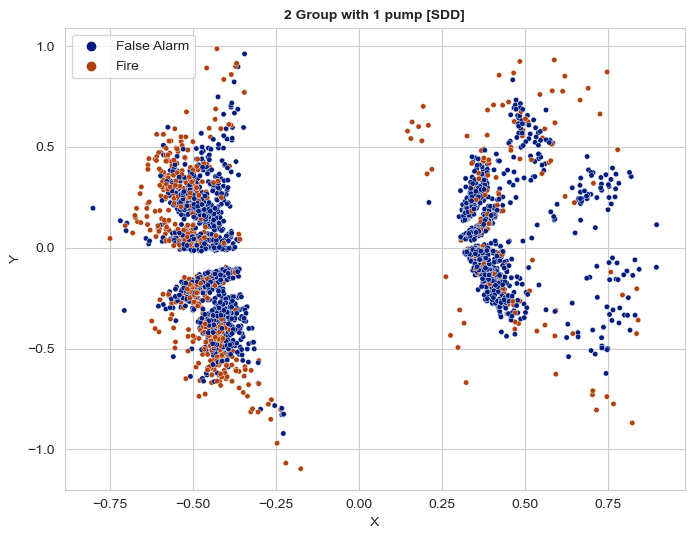

In [50]:
sdd_df1 = sdd_df1[sdd_df1.label != 'Special Service']
fig, ax = plt.subplots(1, figsize=(8,6))
sns.scatterplot(x = sdd_df1.X, y= sdd_df1.Y, data = sdd_df1, hue='label', ax = ax, s=15, palette = 'dark')
palette = sns.color_palette("bright", 2)
sns.set_style('whitegrid')
# lim = (tsne_df.min()-5, tsne_df.max()+5)
ax.set_title('2 Group with 1 pump [SDD]', fontsize = 10, weight = 'bold')
# ax.legend(bbox_to_anchor = (1,1), loc =2, borderaxespad = 0.0)
plt.legend()

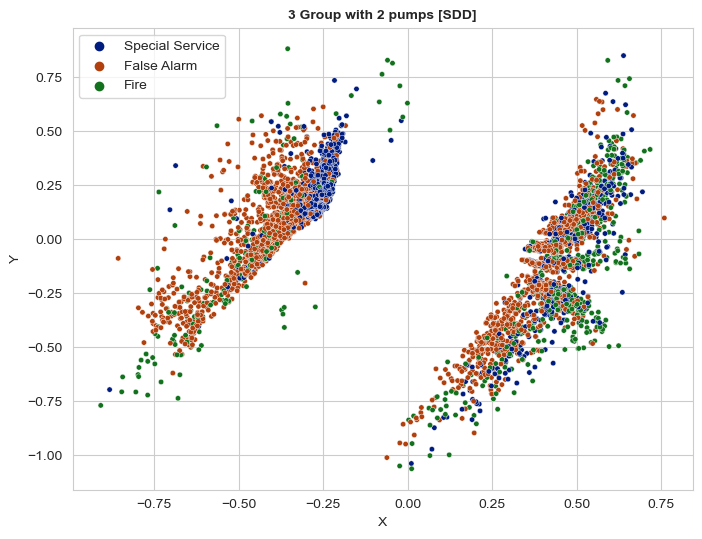

In [51]:
# Plotting the sdd data

fig, ax = plt.subplots(1, figsize=(8,6))
sns.scatterplot(x = sdd_df2.X, y= sdd_df2.Y, data = sdd_df2, hue='label', ax = ax, s=15, palette = 'dark')
palette = sns.color_palette("bright", 2)
sns.set_style('whitegrid')
# lim = (tsne_df.min()-5, tsne_df.max()+5)
ax.set_title('3 Group with 2 pumps [SDD]', fontsize = 10, weight = 'bold')
# ax.legend(bbox_to_anchor = (1,1), loc =2, borderaxespad = 0.0)
plt.legend()

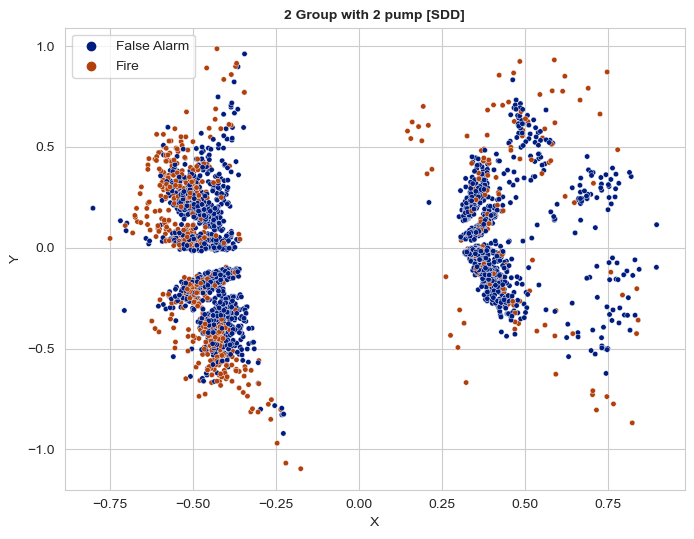

In [52]:
sdd_df2 = sdd_df2[sdd_df2.label != 'Special Service']
fig, ax = plt.subplots(1, figsize=(8,6))
sns.scatterplot(x = sdd_df1.X, y= sdd_df1.Y, data = sdd_df2, hue='label', ax = ax, s=15, palette = 'dark')
palette = sns.color_palette("bright", 2)
sns.set_style('whitegrid')
# lim = (tsne_df.min()-5, tsne_df.max()+5)
ax.set_title('2 Group with 2 pump [SDD]', fontsize = 10, weight = 'bold')
# ax.legend(bbox_to_anchor = (1,1), loc =2, borderaxespad = 0.0)
plt.legend()

### Radar plot

In [53]:
computed = TSNE(n_components=1, learning_rate='auto',
                  init='random', perplexity=50).fit_transform(X_df2)

In [54]:
computed_df = pd.concat([X_df2, pd.DataFrame(abs(computed), columns=['computed']), label], axis=1)
computed_df=computed_df[computed_df.IncidentGroup != 'Special Service']
computed_df.head()

,CalYear,HourOfCall,Easting_m,Northing_m,Easting_rounded,Northing_rounded,FirstPumpArriving_AttendanceTime,SecondPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,...,DayOfcall_24,DayOfcall_25,DayOfcall_26,DayOfcall_27,DayOfcall_28,DayOfcall_29,DayOfcall_30,DayOfcall_31,computed,IncidentGroup
3,1.333333,0.956522,1.894217,1.804395,1.939394,0.121212,0.439149,0.000000,0.52548,0.457868,...,0,0,0,0,0,0,1,0,17.696289,False Alarm
4,1.333333,0.173913,1.866967,1.725122,0.404040,0.545455,0.721851,0.000000,0.52548,0.457868,...,0,0,0,0,0,1,0,0,25.030508,False Alarm
6,0.666667,2.000000,1.895669,1.801598,0.000000,0.060606,0.529723,0.000000,0.52548,0.457868,...,0,0,0,0,0,0,0,0,18.917948,False Alarm
8,1.333333,0.608696,1.878768,1.802557,1.070707,0.080808,0.735574,0.812545,1.05096,0.915736,...,0,0,0,0,0,0,0,0,18.384531,False Alarm
9,0.666667,2.000000,1.855087,1.672450,1.757576,1.494949,0.444638,0.000000,0.52548,0.457868,...,0,0,0,0,0,0,0,0,35.580688,Fire


In [55]:
correlation=computed_df.groupby(['IncidentGroup']).mean()
correlation.loc[:,"Incident Total"] = correlation.sum(axis=1)-correlation['computed']
correlation=correlation.T
correlation.head()

IncidentGroup,False Alarm,Fire
CalYear,1.001619,0.951797
HourOfCall,1.162471,1.247229
Easting_m,0.910310,1.337289
Northing_m,0.865047,1.271099
Easting_rounded,1.000286,1.003095


In [56]:
correlation=correlation.sort_values(['Fire', 'False Alarm'], ascending =[False, False])
correlation

IncidentGroup,False Alarm,Fire
computed,23.072414,31.500856
Incident Total,17.644592,18.367363
Easting_m,0.910310,1.337289
Northing_m,0.865047,1.271099
HourOfCall,1.162471,1.247229
...,...,...
PropertyType_Roadside furniture (eg lamp posts/ road signs/ telegraph poles/ speed cameras),0.000000,0.000000
PropertyType_Shelter,0.000000,0.000000
PropertyType_Temporary office (eg portacabin),0.000000,0.000000
PropertyType_Tunnel/ subway,0.000000,0.000000


In [57]:
correlation.to_csv("corr1.csv")